# Sentinel Hub Process API

In this example notebook we show how to use Sentinel Hub Process API to download NDVI data from Sentinel-2 imagery. 

## Prerequisites

### Credentials

Process API requires Sentinel Hub account. Please check [configuration instructions](https://sentinelhub-py.readthedocs.io/en/latest/configure.html) about how to set up your Sentinel Hub credentials.

In [37]:
from sentinelhub import SHConfig

config = SHConfig()

if not config.sh_client_id or not config.sh_client_secret:
    print("Warning! To use Process API, please provide the credentials (OAuth client ID and client secret).")

###  Imports 

In [38]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [30]:
import datetime
import os

import matplotlib.pyplot as plt
import numpy as np

from sentinelhub import (
    CRS,
    BBox,
    DataCollection,
    DownloadRequest,
    MimeType,
    MosaickingOrder,
    SentinelHubDownloadClient,
    SentinelHubRequest,
    bbox_to_dimensions,
)

# The following is not a package. It is a file utils.py which should be in the same folder as this notebook.
from utils import plot_image

### Setting area of interest

We will download NDVI from Sentinel-2 imagery of [Betsiboka Estuary](https://en.wikipedia.org/wiki/Betsiboka_River).

The bounding box in `WGS84` coordinate system is `[46.16, -16.15, 46.51, -15.58]` (longitude and latitude coordinates of lower left and upper right corners). You can get the bbox for a different area at the [bboxfinder](http://bboxfinder.com/) website.

All requests require bounding box to be given as an instance of `sentinelhub.geometry.BBox` with corresponding Coordinate Reference System (`sentinelhub.constants.CRS`). In our case it is in _WGS84_ and we can use the predefined _WGS84_ coordinate reference system from `sentinelhub.constants.CRS`.

In [39]:
betsiboka_coords_wgs84 = (46.16, -16.15, 46.51, -15.58)

When the bounding box bounds have been defined, you can initialize the `BBox` of the area of interest. Using the `bbox_to_dimensions` utility function, you can provide the desired resolution parameter of the image in meters and obtain the output image shape.

In [40]:
resolution = 60
betsiboka_bbox = BBox(bbox=betsiboka_coords_wgs84, crs=CRS.WGS84)
betsiboka_size = bbox_to_dimensions(betsiboka_bbox, resolution=resolution)

print(f"Image shape at {resolution} m resolution: {betsiboka_size} pixels")

Image shape at 60 m resolution: (631, 1047) pixels


## NDVI on a specific date

We build the request according to the [API Reference](https://docs.sentinel-hub.com/api/latest/reference/), using the `SentinelHubRequest` class. Each Process API request also needs an [evalscript](https://docs.sentinel-hub.com/api/latest/#/Evalscript/V3/README).

In this example we show how to retrieve the NDVI index from Sentinel-2 data. Using the evalscript allows us to offload the computation of the index to the Sentinel Hub service, without needing to download the raw bands. 

The information that we specify in the `SentinelHubRequest` object is: 

 * the evalscript,
 * a list of input data collections with time interval,
 * a format of the response,
 * a bounding box and it's size (size or resolution).


In [41]:
evalscript_ndvi = """
    //VERSION=3

    function setup() {
        return {
            input: [{
                bands: ["B04", "B08"]
            }],
            output: {
                bands: 1
            }
        };
    }

    function evaluatePixel(sample) {
        let ndvi = index(sample.B08, sample.B04);

        return [ndvi];
    }
"""

request_ndvi = SentinelHubRequest(
    evalscript=evalscript_ndvi,
    input_data=[
        SentinelHubRequest.input_data(
            data_collection=DataCollection.SENTINEL2_L1C,
            time_interval=("2020-06-12", "2020-06-13"),
        )
    ],
    responses=[SentinelHubRequest.output_response("default", MimeType.PNG)],
    bbox=betsiboka_bbox,
    size=betsiboka_size,
    config=config,
)

In [42]:
ndvi_imgs = request_ndvi.get_data()

The method `get_data()` will always return a list of length 1 with the available image from the requested time interval in the form of numpy arrays. 

In [43]:
print(f"Returned data is of type = {type(ndvi_imgs)} and length {len(ndvi_imgs)}.")
print(f"Single element in the list is of type {type(ndvi_imgs[-1])} and has shape {ndvi_imgs[-1].shape}")

Returned data is of type = <class 'list'> and length 1.
Single element in the list is of type <class 'numpy.ndarray'> and has shape (1047, 631)


Image type: uint8


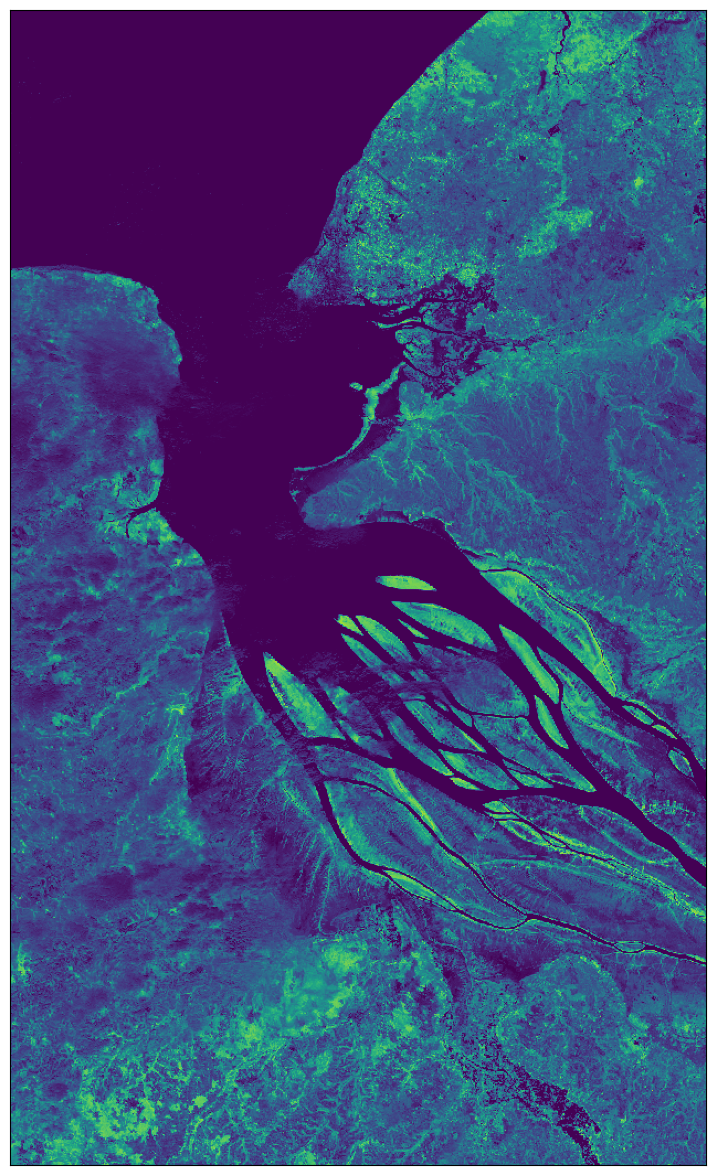

In [44]:
image = ndvi_imgs[0]
print(f"Image type: {image.dtype}")

# plot function
# factor 1/255 to scale between 0-1
plot_image(image, factor=1/255, clip_range=(0, 1))